In [ ]:
pip install darts

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import ETTh1Dataset

In [3]:
series = ETTh1Dataset().load()

In [4]:
train, test = series[:-96], series[-96:]

In [5]:
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

tide = TiDEModel(
    input_chunk_length = 720,
    output_chunk_length = 96,
    num_encoder_layers = 2,
    num_decoder_layers = 2,
    decoder_output_dim = 32,
    hidden_size = 512,
    temporal_decoder_hidden = 16,
    use_layer_norm = True,
    dropout = 0.5,
    random_state = 42)

tide.fit(
    scaled_train,
    epochs = 10
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 6.2 M 
4 | decoders         | Sequential       | 4.2 M 
5 | temporal_decoder | _ResidualBlock   | 892   
6 | lookback_skip    | Linear           | 69.2 K
------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.978    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TiDEModel(num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=16, use_layer_norm=True, dropout=0.5, use_static_covariates=True, input_chunk_length=720, output_chunk_length=96, random_state=42)

In [6]:
scaled_pred_tide = tide.predict(n=96)

pred_tide = train_scaler.inverse_transform(scaled_pred_tide)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
preds_df = pred_tide.pd_dataframe()
test_df = test.pd_dataframe()

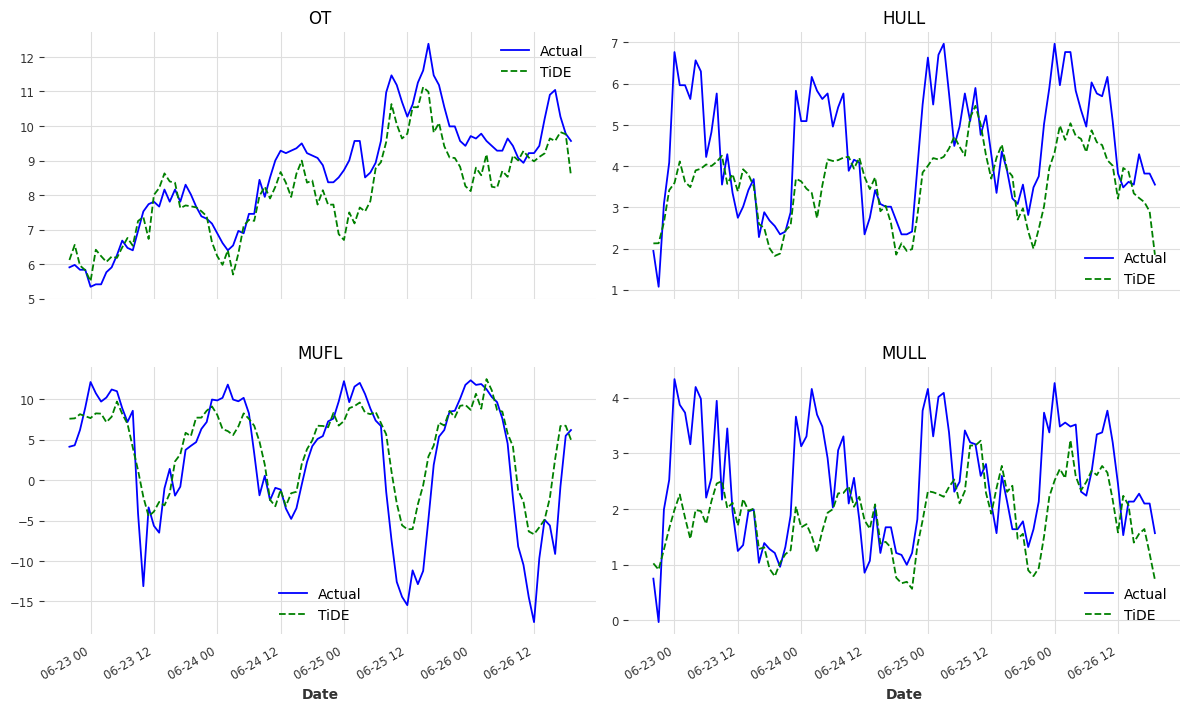

In [8]:
cols_to_plot = ['OT', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]

    ax.plot(test_df[col], label='Actual', ls='-', color='blue')
    ax.plot(preds_df[col], label='TiDE', ls='--', color='green')

    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_title(col)

plt.tight_layout()
fig.autofmt_xdate()

In [9]:
from darts.metrics import mae, mse

tide_mae = mae(test, pred_tide)
tide_mse = mse(test, pred_tide)

print(tide_mae, tide_mse)

1.393040555849576 5.983529192461417


In [10]:
data = {'TiDE':
            [tide_mae,
             tide_mse],
       'TSMixer':
            [1.611139,
             5.231349]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,TiDE,TSMixer
mae,1.393041,1.611139
mse,5.983529,5.231349
